# Linear Support Vector Classification

In this notebook, we will try the model [Linear Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC).

In [1]:
import pickle
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

We load our data

In [2]:
path='/home/maggie/News_classifier/4.Features_Creation/' 

# data
with open(path + 'data_modified.pickle', 'rb') as file:
    data=pickle.load(file)

# features_train
with open(path + 'features_train.pickle', 'rb') as file:
    features_train=pickle.load(file)

# features_test
with open(path + 'features_test.pickle', 'rb') as file:
    features_test=pickle.load(file)
    
# y_train
with open(path + 'y_train.pickle', 'rb') as file:
    y_train=pickle.load(file)
    
# y_test
with open(path + 'y_test.pickle', 'rb') as file:
    y_test=pickle.load(file)

In [3]:
print(features_train.shape)
print(features_test.shape)

(16728, 8257)
(7170, 8257)


## Hyperparameter tuning

In [4]:
lsvc0 =LinearSVC(random_state=42)

print('Parameters:\n')
pprint(lsvc0.get_params())

Parameters:

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}


We will tune only the following parameter:

**C**=Regularization parameter. The strength of the regularization is inversely proportional to C 

In [5]:
# Create the parameter grid 
#C 
C=[0.0001,0.001,0.01,0.1,1,10]

param_grid = {
'C': C,
}

# Base model
lsvc =LinearSVC(random_state=42)


# Grid search model
grid_search = GridSearchCV(estimator=lsvc, 
                            param_grid=param_grid,
                            scoring='accuracy',
                            verbose=12)

# Fit the grid search to the data
grid_search.fit(features_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=0.0001....................................................
[CV 1/5; 1/6] END .....................C=0.0001;, score=0.357 total time=   0.1s
[CV 2/5; 1/6] START C=0.0001....................................................
[CV 2/5; 1/6] END .....................C=0.0001;, score=0.363 total time=   0.1s
[CV 3/5; 1/6] START C=0.0001....................................................
[CV 3/5; 1/6] END .....................C=0.0001;, score=0.364 total time=   0.1s
[CV 4/5; 1/6] START C=0.0001....................................................
[CV 4/5; 1/6] END .....................C=0.0001;, score=0.362 total time=   0.2s
[CV 5/5; 1/6] START C=0.0001....................................................
[CV 5/5; 1/6] END .....................C=0.0001;, score=0.354 total time=   0.2s
[CV 1/5; 2/6] START C=0.001.....................................................
[CV 1/5; 2/6] END ......................C=0.001;,

GridSearchCV(estimator=LinearSVC(random_state=42),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring='accuracy', verbose=12)

In [6]:
print("The best hyperparameters from GridSearchCV are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a LinearSVC model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from GridSearchCV are:
{'C': 0.1}

The mean accuracy of a LinearSVC model with these hyperparameters is:
0.8570059960490941


We save the model with the best hyperparameters

In [7]:
best_lsvc= grid_search.best_estimator_

The class LinearSVC does not have the method predict_proba, so we use CalibratedClassifierCV.

In [8]:
best_lsvc = CalibratedClassifierCV(best_lsvc)

## Model fit

We fit the model to the training data.

In [9]:
best_lsvc.fit(features_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.1, random_state=42))

## Model performance

### - Training accuracy

In [10]:
print("The training accuracy  is: ")
accuracy_train=accuracy_score(y_train,best_lsvc.predict(features_train))
print(accuracy_train)

The training accuracy  is: 
0.9101506456241033


### - Test accuracy

In [11]:
print("The test accuracy is: ")
lsvc_pred = best_lsvc.predict(features_test)
accuracy_test=accuracy_score(y_test, lsvc_pred)
print(accuracy_test)

The test accuracy is: 
0.8592747559274756


### - Classification report and confusion matrix

Classification report
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       904
           1       0.96      0.96      0.96      1448
           2       0.84      0.86      0.85      1276
           3       0.83      0.83      0.83      1073
           4       0.84      0.80      0.82      1392
           5       0.76      0.79      0.78      1077

    accuracy                           0.86      7170
   macro avg       0.86      0.86      0.86      7170
weighted avg       0.86      0.86      0.86      7170



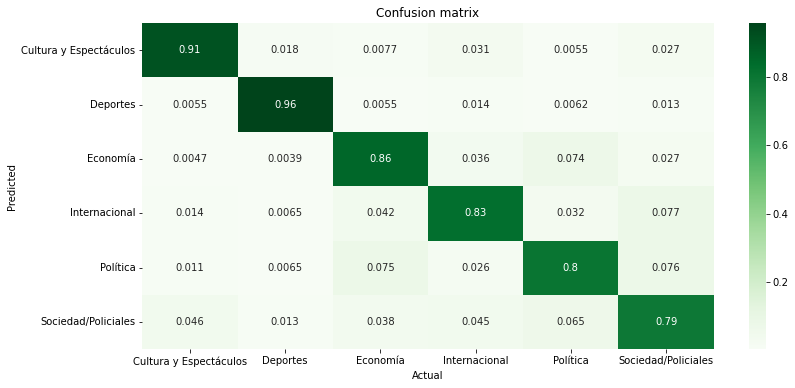

In [12]:
#Classification report
print("Classification report")
print(classification_report(y_test,lsvc_pred))


#Confusion matrix
aux_data = data[['Label', 'Label_code']].drop_duplicates().sort_values('Label_code')
conf_matrix = confusion_matrix(y_test, lsvc_pred,normalize='true')
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, annot=True,
            xticklabels=aux_data['Label'], 
            yticklabels=aux_data['Label'],
            cmap="Greens")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

We save our model.

In [13]:
with open('best_lsvc.pickle', 'wb') as output:
    pickle.dump(best_lsvc, output)

We also save the scores for the different metrics we considered. In the case of precision, recall and F1-score we use macro average (averaging the unweighted mean per label).

In [14]:
classification_report_macro=classification_report(y_test,lsvc_pred,output_dict=True)['macro avg']
scores_lsvc = {
     'Model': 'Linear Support Vector Classification',
     'Training Set Accuracy': accuracy_train,
     'Test Set Accuracy': accuracy_test,
     'Precision':classification_report_macro['precision'],
    'Recall':classification_report_macro['recall'],
    'F1-score':classification_report_macro['f1-score']
}

In [15]:
scores_lsvc

{'Model': 'Linear Support Vector Classification',
 'Training Set Accuracy': 0.9101506456241033,
 'Test Set Accuracy': 0.8592747559274756,
 'Precision': 0.8562973725478442,
 'Recall': 0.8579086557182035,
 'F1-score': 0.8569654836919746}

In [16]:
with open('scores_lsvc.pickle', 'wb') as handle:
    pickle.dump(scores_lsvc, handle, protocol=pickle.HIGHEST_PROTOCOL)